In [1]:
import os
import numpy as np
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from PIL import Image
from torch.utils.data import Subset
from torch.optim import Optimizer
from sklearn.model_selection import train_test_split
from torchvision.models import vgg16
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
SEED = 42 # For reproducibility

# Image transformer
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
# Batch size for training and testing
TRAIN_BATCHSIZE = 128
TEST_BATCHSIZE = 64

# Download dataset
train_dataset = MNIST('./data', transform=img_transform, download=True, train=True)
test_dataset = MNIST('./data', transform=img_transform, download=True, train=False)

# Dataset length
num_train = len(train_dataset)
num_test = len(test_dataset)
print(f"Num. training samples: {num_train}")
print(f"Num. test samples:     {num_test}")

# Fraction of the original train set that we want to use as validation set
val_frac = 0.2
# Number of samples of the validation set
num_val = int(num_train * val_frac) 
num_train = num_train - num_val

print(f"{num_train} samples used as train dataset")
print(f"{num_val}  samples used as val dataset")

# Split train_dataset into training and validation
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [num_train, num_val], 
                                                           generator=torch.Generator().manual_seed(SEED))
# Build dataloaders
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCHSIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=TEST_BATCHSIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCHSIZE, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Num. training samples: 60000
Num. test samples:     10000
48000 samples used as train dataset
12000  samples used as val dataset


In [3]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        conv2_params = {
            'kernel_size': (3, 3),
            'stride'     : (1, 1),
            'padding'   : 1
        }
        noop = lambda x : x

        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)
        return x
    
class VGG16(nn.Module):
    def __init__(self, config):
        super(VGG16, self).__init__()
        self.config = config
        self.in_channels, self.in_width, self.in_height = config.input_size

        self.block_1 = VGGBlock(self.in_channels, 64, batch_norm=config.batch_norm)
        self.block_2 = VGGBlock(64, 128,batch_norm=config.batch_norm)
        self.block_3 = VGGBlock(128, 256,batch_norm=config.batch_norm)
        self.block_4 = VGGBlock(256, 512,batch_norm=config.batch_norm)

        self.classifier = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(True),
                nn.Dropout(p=0.3),
                nn.Linear(256, 128),
                nn.ReLU(True),
                nn.Dropout(p=0.1),
                nn.Linear(128, config.num_classes) 
            )

    @property
    def input_size(self):
        return self.in_channels,self.in_width,self.in_height

    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x
    
    @staticmethod
    def _init_model_with_state_dict(state):
        model = VGG16(state['model_config'])
        model.load_state_dict(state['model_state_dict'])
        return model
    
    @classmethod
    def load(cls, path):
        r"""
        Loads a model with data fields and pretrained model parameters.
        Args:
            path (str):
                - a string with the shortcut name of a pretrained learner
                  to load from .pt file.
        Examples:
            >>> # model = VGG16.load('./tmp/resources/<model_name>.pt')
        """
        if os.path.exists(path):
            state = torch.load(path)
        else:
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), path)
        model = cls._init_model_with_state_dict(state)
        return model

In [4]:

class AdamOptimizer(Optimizer):
    """
    implements ADAM Algorithm, as a preceding step.
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdamOptimizer, self).__init__(params, defaults)
        
    def step(self):
        import math
        """
        Performs a single optimization step.
        """
        loss = None
        for group in self.param_groups:

            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Momentum (Exponential MA of gradients)
                    state['exp_avg'] = torch.zeros_like(p.data)
                    #print(p.data.size())
                    # RMS Prop componenet. (Exponential MA of squared gradients). Denominator.
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                b1, b2 = group['betas']
                state['step'] += 1
                
                # L2 penalty. Gotta add to Gradient as well.
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Momentum
                exp_avg = torch.mul(exp_avg, b1) + (1 - b1)*grad
                # RMS
                exp_avg_sq = torch.mul(exp_avg_sq, b2) + (1-b2)*(grad*grad)
                
                denom = exp_avg_sq.sqrt() + group['eps']

                bias_correction1 = 1 / (1 - b1 ** state['step'])
                bias_correction2 = 1 / (1 - b2 ** state['step'])
                
                adapted_learning_rate = group['lr'] * bias_correction1 / math.sqrt(bias_correction2)

                p.data = p.data - adapted_learning_rate * exp_avg / denom 

        return loss

class SgdOptimizer(Optimizer):
    """Implements SGD Algorithm
    The Nesterov version can be performed by choosing input argument
    """
    def __init__(self, 
        params, 
        lr=1e-3, 
        momentum=0, 
        dampening=0,
        weight_decay=0, 
        nesterov=False):

        defaults = dict(lr=lr, momentum=momentum,
                        dampening=dampening,
                        weight_decay=weight_decay, 
                        nesterov=nesterov)

        super(SgdOptimizer, self).__init__(params, defaults)

    def step(self):
        loss = None
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        buf.mul_(momentum).add_(d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-group['lr'], d_p)

        return loss

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TrainingArgs:
    def __init__(self):
        self.lr = 1e-3
        self.num_epochs = 20
        self.input_size = (1,28,28)
        self.num_classes = 10
        self.optimizer = 'sgd'
        self.batch_norm = True
        self.nesterov = False
        self.momentum = 0
        self.weight_decay = 0
        
args = TrainingArgs()

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = VGG16(args).to(device)

print(">> Model's Architecture: ")
print(model)
print(f">> Total parameters: {count_parameters(model)}")

>> Model's Architecture: 
VGG16(
  (block_1): VGGBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): VGGBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): VGGBlock

In [7]:
criterion = nn.CrossEntropyLoss()

if args.optimizer == 'adam':
    optim = AdamOptimizer(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
else:
    optim = SgdOptimizer(model.parameters(), lr=args.lr, 
                         weight_decay=args.weight_decay, 
                         momentum=args.momentum, nesterov=args.nesterov)

In [8]:
history = {'acc': {'train': [], 'val': []}, 
    'loss': {'train': [], 'val': []}}
min_val_loss = np.inf

for epoch in range(args.num_epochs):
    # Training
    train_iterator = tqdm(train_loader, leave=True)
    running_train_loss = 0.0
    running_train_acc = 0.0
    model.train()
    for i, (images, labels) in enumerate(train_iterator):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_acc = ((outputs.argmax(dim=1) == labels).float().mean())        
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Gather training loss and acc
        running_train_loss += loss.item()
        running_train_acc += train_acc.item()
        
        train_iterator.set_description('(Train) Epoch [{}/{}]'.format(epoch, args.num_epochs))
        train_iterator.set_postfix(train_loss=loss.item(), train_acc=train_acc.item())

    epoch_train_loss = running_train_loss/len(train_loader)
    epoch_train_acc = running_train_acc/len(train_loader)

    history['acc']['train'].append(epoch_train_acc)
    history['loss']['train'].append(epoch_train_loss)
    
    # Evaluation
    val_iterator = tqdm(val_loader, leave=True)
    running_val_loss = 0.0
    running_val_acc = 0.0
    model.eval()
    for vidx, (val_images, val_labels) in enumerate(val_iterator):
        with torch.no_grad():
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_acc = ((val_outputs.argmax(dim=1) == val_labels).float().mean())

            running_val_loss += val_loss.item()
            running_val_acc += val_acc.item()
            
            val_iterator.set_description('(Val) Epoch [{}/{}]'.format(epoch, args.num_epochs))
            val_iterator.set_postfix(val_loss=val_loss.item(), val_acc=val_acc.item())
            
    epoch_val_acc = running_val_acc/len(val_loader)
    epoch_val_loss = running_val_loss/len(val_loader)

    history['acc']['val'].append(epoch_val_acc)
    history['loss']['val'].append(epoch_val_loss)
    
    print(f'>> Epoch [{epoch+1}/{args.num_epochs}]:\tTrain loss = {epoch_train_loss:.5f} | Val loss = {epoch_val_loss:.5f},\
                \t Train Acc = {epoch_train_acc:.5f} | Val Acc = {epoch_val_acc:.5f}')
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        print(">> Saving The Model Checkpoint")
        torch.save(
            {
                'model_config': model.config,
                'model_state_dict': model.state_dict(),
                'optim_state_dict': optim.state_dict(),
                'history': history
            }, './vgg16-sgd-mnist.pt'
        )

(Val) Epoch [0/20]: 100%|██████████| 188/188 [00:03<00:00, 48.14it/s, val_acc=0.875, val_loss=1.41]


>> Epoch [1/20]:	Train loss = 1.97369 | Val loss = 1.39280,                	 Train Acc = 0.48254 | Val Acc = 0.88389
>> Saving The Model Checkpoint


(Val) Epoch [1/20]: 100%|██████████| 188/188 [00:03<00:00, 50.05it/s, val_acc=0.969, val_loss=0.441]


>> Epoch [2/20]:	Train loss = 0.95115 | Val loss = 0.46455,                	 Train Acc = 0.86479 | Val Acc = 0.94274
>> Saving The Model Checkpoint


(Val) Epoch [2/20]: 100%|██████████| 188/188 [00:04<00:00, 42.65it/s, val_acc=0.969, val_loss=0.176]


>> Epoch [3/20]:	Train loss = 0.39151 | Val loss = 0.21552,                	 Train Acc = 0.93815 | Val Acc = 0.96061
>> Saving The Model Checkpoint


(Val) Epoch [3/20]: 100%|██████████| 188/188 [00:03<00:00, 49.83it/s, val_acc=0.969, val_loss=0.102] 


>> Epoch [4/20]:	Train loss = 0.22319 | Val loss = 0.13839,                	 Train Acc = 0.95894 | Val Acc = 0.96958
>> Saving The Model Checkpoint


(Val) Epoch [4/20]: 100%|██████████| 188/188 [00:05<00:00, 34.39it/s, val_acc=0.969, val_loss=0.0831]


>> Epoch [5/20]:	Train loss = 0.16013 | Val loss = 0.10595,                	 Train Acc = 0.96681 | Val Acc = 0.97440
>> Saving The Model Checkpoint


(Val) Epoch [5/20]: 100%|██████████| 188/188 [00:03<00:00, 50.96it/s, val_acc=0.969, val_loss=0.0626]


>> Epoch [6/20]:	Train loss = 0.12428 | Val loss = 0.08749,                	 Train Acc = 0.97294 | Val Acc = 0.97689
>> Saving The Model Checkpoint


(Val) Epoch [6/20]: 100%|██████████| 188/188 [00:03<00:00, 49.57it/s, val_acc=0.969, val_loss=0.0571]


>> Epoch [7/20]:	Train loss = 0.10347 | Val loss = 0.07581,                	 Train Acc = 0.97733 | Val Acc = 0.97939
>> Saving The Model Checkpoint


(Val) Epoch [7/20]: 100%|██████████| 188/188 [00:03<00:00, 49.09it/s, val_acc=0.969, val_loss=0.0503]


>> Epoch [8/20]:	Train loss = 0.08812 | Val loss = 0.06760,                	 Train Acc = 0.97971 | Val Acc = 0.98221
>> Saving The Model Checkpoint


(Val) Epoch [8/20]: 100%|██████████| 188/188 [00:03<00:00, 50.12it/s, val_acc=0.969, val_loss=0.0544]


>> Epoch [9/20]:	Train loss = 0.07791 | Val loss = 0.06145,                	 Train Acc = 0.98160 | Val Acc = 0.98280
>> Saving The Model Checkpoint


(Val) Epoch [9/20]: 100%|██████████| 188/188 [00:03<00:00, 50.44it/s, val_acc=0.969, val_loss=0.0436]


>> Epoch [10/20]:	Train loss = 0.06884 | Val loss = 0.05701,                	 Train Acc = 0.98367 | Val Acc = 0.98354
>> Saving The Model Checkpoint


(Val) Epoch [10/20]: 100%|██████████| 188/188 [00:03<00:00, 53.61it/s, val_acc=0.969, val_loss=0.044] 


>> Epoch [11/20]:	Train loss = 0.06326 | Val loss = 0.05325,                	 Train Acc = 0.98490 | Val Acc = 0.98396
>> Saving The Model Checkpoint


(Val) Epoch [11/20]: 100%|██████████| 188/188 [00:03<00:00, 51.92it/s, val_acc=0.969, val_loss=0.0451]


>> Epoch [12/20]:	Train loss = 0.05607 | Val loss = 0.04998,                	 Train Acc = 0.98662 | Val Acc = 0.98546
>> Saving The Model Checkpoint


(Val) Epoch [12/20]: 100%|██████████| 188/188 [00:03<00:00, 52.64it/s, val_acc=0.969, val_loss=0.0366]


>> Epoch [13/20]:	Train loss = 0.05309 | Val loss = 0.04776,                	 Train Acc = 0.98721 | Val Acc = 0.98570
>> Saving The Model Checkpoint


(Val) Epoch [13/20]: 100%|██████████| 188/188 [00:03<00:00, 51.49it/s, val_acc=0.969, val_loss=0.0366]


>> Epoch [14/20]:	Train loss = 0.04688 | Val loss = 0.04624,                	 Train Acc = 0.98894 | Val Acc = 0.98637
>> Saving The Model Checkpoint


(Val) Epoch [14/20]: 100%|██████████| 188/188 [00:03<00:00, 51.29it/s, val_acc=0.969, val_loss=0.0339]


>> Epoch [15/20]:	Train loss = 0.04467 | Val loss = 0.04302,                	 Train Acc = 0.98915 | Val Acc = 0.98720
>> Saving The Model Checkpoint


(Val) Epoch [15/20]: 100%|██████████| 188/188 [00:03<00:00, 47.19it/s, val_acc=0.969, val_loss=0.0326]


>> Epoch [16/20]:	Train loss = 0.04015 | Val loss = 0.04197,                	 Train Acc = 0.99062 | Val Acc = 0.98703
>> Saving The Model Checkpoint


(Val) Epoch [16/20]: 100%|██████████| 188/188 [00:03<00:00, 51.82it/s, val_acc=1, val_loss=0.0245]    


>> Epoch [17/20]:	Train loss = 0.03812 | Val loss = 0.04048,                	 Train Acc = 0.99073 | Val Acc = 0.98753
>> Saving The Model Checkpoint


(Val) Epoch [17/20]: 100%|██████████| 188/188 [00:03<00:00, 51.95it/s, val_acc=0.969, val_loss=0.0316]


>> Epoch [18/20]:	Train loss = 0.03558 | Val loss = 0.03943,                	 Train Acc = 0.99181 | Val Acc = 0.98770
>> Saving The Model Checkpoint


(Val) Epoch [18/20]: 100%|██████████| 188/188 [00:03<00:00, 48.00it/s, val_acc=1, val_loss=0.0238]    


>> Epoch [19/20]:	Train loss = 0.03292 | Val loss = 0.03840,                	 Train Acc = 0.99260 | Val Acc = 0.98762
>> Saving The Model Checkpoint


(Val) Epoch [19/20]: 100%|██████████| 188/188 [00:03<00:00, 51.61it/s, val_acc=1, val_loss=0.0212]    


>> Epoch [20/20]:	Train loss = 0.03137 | Val loss = 0.03732,                	 Train Acc = 0.99277 | Val Acc = 0.98812
>> Saving The Model Checkpoint


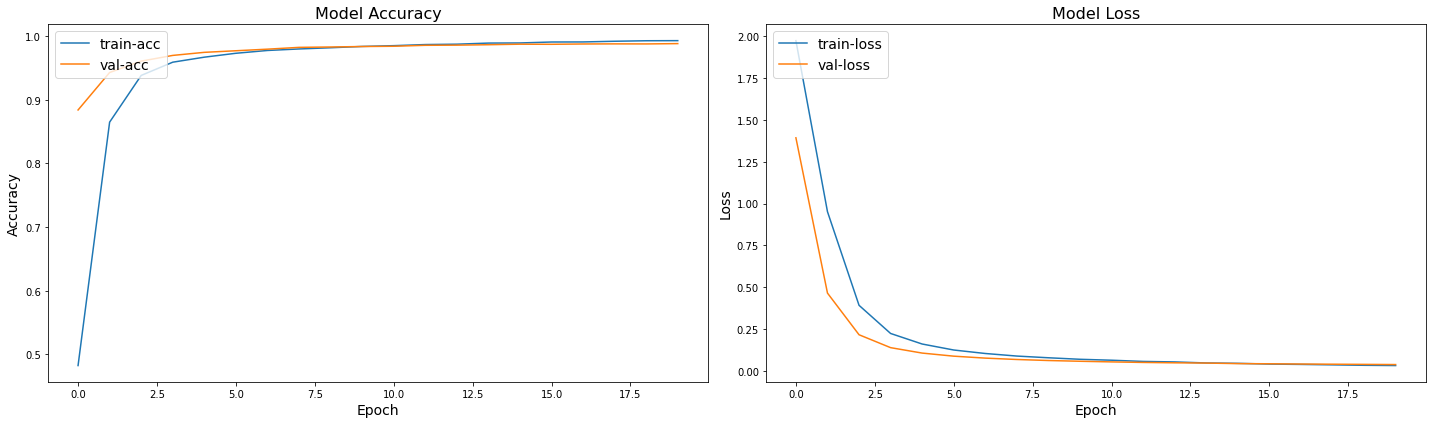

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(20,6))

axs[0].plot(np.arange(len(history['acc']['train'])), history['acc']['train'])
axs[0].plot(np.arange(len(history['acc']['val'])), history['acc']['val'])
axs[0].set_title('Model Accuracy', fontsize = 16)
axs[0].set_ylabel('Accuracy', fontsize = 14)
axs[0].set_xlabel('Epoch', fontsize = 14)
axs[0].legend(['train-acc', 'val-acc'], loc='upper left', fontsize = 14)

axs[1].plot(np.arange(len(history['loss']['train'])), history['loss']['train'])
axs[1].plot(np.arange(len(history['loss']['val'])), history['loss']['val'])
axs[1].set_title('Model Loss', fontsize = 16)
axs[1].set_ylabel('Loss', fontsize = 14)
axs[1].set_xlabel('Epoch', fontsize = 14)
axs[1].legend(['train-loss', 'val-loss'], loc='upper left', fontsize = 14)

plt.tight_layout()
plt.show()

In [11]:
best_model = VGG16.load('./vgg16-sgd-mnist.pt').to(device)

In [13]:
best_model.eval()
test_iterator = tqdm(test_loader, leave=True)
running_test_loss, running_test_acc = 0.0, 0.0
for tidx, (test_images, test_labels) in enumerate(test_iterator):
    with torch.no_grad():
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        test_outputs = best_model(test_images)
        test_loss = criterion(test_outputs, test_labels)
        test_acc = ((test_outputs.argmax(dim=1) == test_labels).float().mean())

        running_test_loss += test_loss.item()
        running_test_acc += test_acc.item()

        test_iterator.set_description('(Test)')
        test_iterator.set_postfix(test_loss=test_loss.item(), test_acc=test_acc.item())

total_test_acc = running_test_acc/len(test_loader)
total_test_loss = running_test_loss/len(test_loader)

print(f'>> Result:\tTest loss = {total_test_loss:.5f} \t Test Acc = {total_test_acc:.5f}')

(Test): 100%|██████████| 157/157 [00:03<00:00, 51.11it/s, test_acc=1, test_loss=0.00108]   

>> Result:	Test loss = 0.02835 	 Test Acc = 0.99094
